## HCP individualized connectome prediction

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset, DataLoader
from data.data_utils import *

In [2]:
participants_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/HCP-YA_dataset/participants.tsv"
participants_df = pd.read_csv(participants_path, sep='\t')

In [3]:
participants_df.head()

participant_id  subject  age sex train_val_test
0     sub-100206   100206   27   M          train
1     sub-100307   100307   27   F          train
2     sub-100408   100408   33   M            val
3     sub-100610   100610   27   M          train
4     sub-101006   101006   35   F            val

In [4]:
# Option to select either "Glasser" or "S456" parcellation
parcellation = "Glasser"  # options: "Glasser" or "S456"

if parcellation == "S456":
    # Use 4S456Parcels data
    sc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_SCifod2actvolnorm.mat"
    fc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_FCcorrhpf.mat"
elif parcellation == "Glasser":
    # Use Glasser data
    sc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_SCifod2actvolnorm.mat"
    fc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_FCcorrhpf.mat"
else:
    raise ValueError(f'Invalid parcellation: must be "Glasser" or "S456"')

# Load the structural connectivity (SC) .mat file
sc_mat = scipy.io.loadmat(sc_mat_path)

sc_subjects = sc_mat['subjects']
sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]

sc_cell = sc_mat['SC']
sc_cell = np.squeeze(sc_cell)  # Make 1D if needed
n_sc_subj = sc_cell.shape[0]
# Each element is nparcel x nparcel
sc_matrices = np.stack([sc_cell[i] for i in range(n_sc_subj)], axis=0)
sc_triangles = np.stack([square2tri(sc_matrices[i], k=1) for i in range(n_sc_subj)], axis=0)

# Load the functional connectivity (FC) .mat file
fc_mat = scipy.io.loadmat(fc_mat_path)

fc_subjects = fc_mat['subjects']
fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]

fc_cell = fc_mat['FC']
fc_cell = np.squeeze(fc_cell)  # Make 1D if needed
n_fc_subj = fc_cell.shape[0]
# Each element is nparcel x nparcel
fc_matrices = np.stack([fc_cell[i] for i in range(n_fc_subj)], axis=0)
fc_triangles = np.stack([square2tri(fc_matrices[i], k=1) for i in range(n_fc_subj)], axis=0)

/tmp/ipykernel_2864035/1198866335.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]
/tmp/ipykernel_2864035/1198866335.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]


In [5]:
print("fc_subjects shape:", np.shape(fc_subjects))
print("fc_matrices shape:", fc_matrices.shape)
print("fc_triangles shape:", fc_triangles.shape, '\n')

print("sc_subjects shape:", np.shape(sc_subjects))
print("sc_matrices shape:", sc_matrices.shape)
print("sc_triangles shape:", sc_triangles.shape)


fc_subjects shape: (957,)
fc_matrices shape: (957, 360, 360)
fc_triangles shape: (957, 64620) 

sc_subjects shape: (957,)
sc_matrices shape: (957, 360, 360)
sc_triangles shape: (957, 64620)


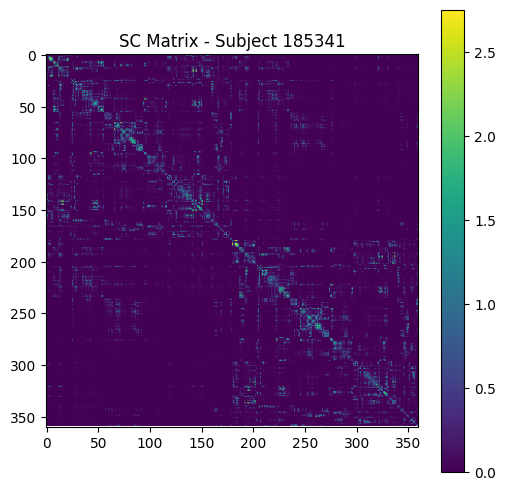

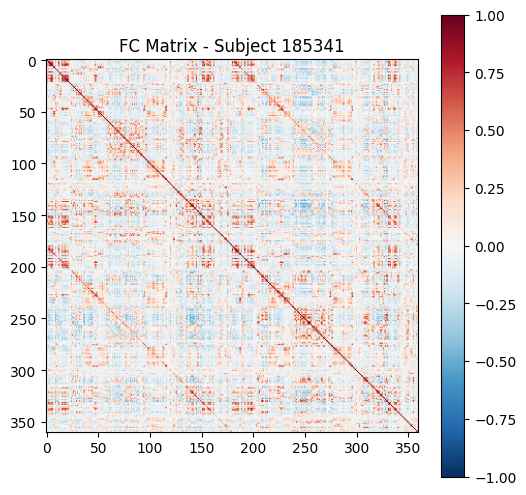

In [6]:
import random
import matplotlib.pyplot as plt

# Pick a random subject index that is present in both SC and FC sets
common_subjects = list(set(sc_subjects) & set(fc_subjects))
if not common_subjects:
    raise ValueError("No subjects in common between SC and FC datasets.")

# Choose a random subject
rand_subject = random.choice(common_subjects)

# Find index of this subject in sc_subjects and fc_subjects
sc_idx = sc_subjects.index(rand_subject)
fc_idx = fc_subjects.index(rand_subject)

# Get the full matrices (not just triangles)
sc_matrix = sc_matrices[sc_idx]
fc_matrix = fc_matrices[fc_idx]

# Plot SC matrix (ensure image is square)
plt.figure(figsize=(6, 6))
plt.imshow(sc_matrix, aspect='equal', cmap='viridis')
plt.title(f"SC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()

# Plot FC matrix (ensure image is square) with colormap RdBu_r and colorbar from -1 to 1
plt.figure(figsize=(6, 6))
plt.imshow(fc_matrix, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title(f"FC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()


Data loader logic walk through

In [7]:
import importlib
import data.hcp_dataset
import data.dataset_utils 
import data.data_utils
importlib.reload(data.hcp_dataset)
importlib.reload(data.dataset_utils)
importlib.reload(data.data_utils)
from data.hcp_dataset import *
from data.dataset_utils import *
from data.data_utils import *

In [8]:
from data.hcp_dataset import HCP_Base

Current 1 min load in

In [14]:
HCP_Dataset = HCP_Base(parcellation="4S456Parcels", shuffle_seed=0)

In [15]:
HCP_Dataset.sc_r2t_matrices.shape

(957, 456, 66)

In [16]:
HCP_Dataset.sc_matrices.shape

(957, 456, 456)

In [17]:
HCP_Dataset.metadata_df.head()

subject train_val_test  age age_3y_bin sex  \
0   100206          train   27      25-27   M   
1   100307          train   27      25-27   F   
2   100408            val   33      31-33   M   
3   100610          train   27      25-27   M   
4   101006            val   35      34-36   F   

                             Race_Ethnicity Family_Relation          Family_ID  
0                 White_Not Hispanic/Latino         NotTwin        56037_85858  
1                 White_Not Hispanic/Latino              MZ        51488_81352  
2                 White_Not Hispanic/Latino              MZ        51730_81594  
3                 White_Not Hispanic/Latino              DZ        52813_82634  
4  Black or African Am._Not Hispanic/Latino              MZ  51283_52850_81149

Process region to tract data and save as common npy files

In [24]:
import os
import numpy as np
import pandas as pd

# Paths and parameters
HCP_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/"
tract_region_dir = os.path.join(HCP_dir, "HCP1200_DTI/qsirecon")
parcellations = ["Glasser", "4S456Parcels"]
num_tracts = 76  # common denominator target

# --- Find the 76 tracts present in sub-100206 as canonical ---

# Find canonical tract set as subject with smallest number of tracts for each parcellation
canonical_tracts_per_parc = {}
min_tract_subj_per_parc = {}
min_tract_count_per_parc = {}

# Step 1: Scan all subjects to find minimum tract count per parcellation and example subject
subject_dirs = [d for d in os.listdir(tract_region_dir) if d.startswith("sub-")]

for parc in parcellations:
    min_count = None
    min_subj = None
    for subj in subject_dirs:
        subj_path = os.path.join(tract_region_dir, subj, "anat", "tract-to-region")
        if not os.path.isdir(subj_path):
            continue
        for f in os.listdir(subj_path):
            if not f.endswith(".csv"): continue
            if parc not in f: continue
            csv_path = os.path.join(subj_path, f)
            df = pd.read_csv(csv_path)
            ntract = df.shape[0]
            if (min_count is None) or (ntract < min_count):
                min_count = ntract
                min_subj = (subj, csv_path)
    min_tract_count_per_parc[parc] = min_count
    min_tract_subj_per_parc[parc] = min_subj

    # Grab tract names from the canonical (minimum) subject+file
    if min_subj is not None:
        df = pd.read_csv(min_subj[1])
        canonical_tracts_per_parc[parc] = set(df.iloc[:,1].values)
    else:
        canonical_tracts_per_parc[parc] = set()

# Step 2: For each parcellation, find and output missing tracts (those that are in a 77-tract subject but missing from canonical set)
for parc in parcellations:
    canonical_tracts = canonical_tracts_per_parc[parc]
    if not canonical_tracts:
        print(f"Could not determine canonical tracts for {parc}")
        continue
    found_77 = False
    for subj in subject_dirs:
        subj_path = os.path.join(tract_region_dir, subj, "anat", "tract-to-region")
        if not os.path.isdir(subj_path): continue
        for f in os.listdir(subj_path):
            if not f.endswith(".csv"): continue
            if parc not in f: continue
            csv_path = os.path.join(subj_path, f)
            df = pd.read_csv(csv_path)
            if df.shape[0] == 77:
                all_tracts_77 = set(df.iloc[:,1].values)
                missing = all_tracts_77 - canonical_tracts
                print(f"Parcellation {parc}: in subject {subj} with 77 tracts, the following {len(missing)} tracts are missing from canonical ({min_tract_count_per_parc[parc]}): {sorted(missing)}")
                found_77 = True
                break
        if found_77:
            break


Parcellation Glasser: in subject sub-749361 with 77 tracts, the following 7 tracts are missing from canonical (70): ['CommissureAnteriorCommissure', 'ProjectionBrainstemCorticobulbarTractL', 'ProjectionBrainstemDentatorubrothalamicTractlr', 'ProjectionBrainstemMedialLemniscusL', 'ProjectionBrainstemMedialLemniscusR', 'ProjectionBrainstemReticularTractL', 'ProjectionBrainstemReticularTractR']
Parcellation 4S456Parcels: in subject sub-749361 with 77 tracts, the following 7 tracts are missing from canonical (70): ['CommissureAnteriorCommissure', 'ProjectionBrainstemCorticobulbarTractL', 'ProjectionBrainstemDentatorubrothalamicTractlr', 'ProjectionBrainstemMedialLemniscusL', 'ProjectionBrainstemMedialLemniscusR', 'ProjectionBrainstemReticularTractL', 'ProjectionBrainstemReticularTractR']


In [44]:
import os
import pandas as pd

# Parameters
HCP_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/"
tract_region_dir = os.path.join(HCP_dir, "HCP1200_DTI/qsirecon")

def summarize_tracts_per_parcellation(
    tract_region_dir, parcellation
):
    """
    Returns the list of tracts that are present in all subjects for a given parcellation,
    and prints the number and their names.
    """
    subject_dirs = [
        d for d in os.listdir(tract_region_dir)
        if os.path.isdir(os.path.join(tract_region_dir, d))
        and d.startswith("sub-")
    ]

    all_tract_sets = []
    for subj in subject_dirs:
        subj_path = os.path.join(tract_region_dir, subj, "anat", "tract-to-region")
        if not os.path.isdir(subj_path):
            continue
        found = False
        for f in os.listdir(subj_path):
            if not f.endswith(".csv"):
                continue
            if parcellation not in f:
                continue
            csv_path = os.path.join(subj_path, f)
            df = pd.read_csv(csv_path)
            tract_names = set(df.iloc[:, 1].values)  # Second column: tract names
            all_tract_sets.append(tract_names)
            found = True
            break  # take only one file per subject
        if not found:
            # Subject didn't have matching file, so can't be included in intersection
            pass

    if not all_tract_sets:
        print(f"No subjects with parcellation '{parcellation}' found.")
        return []

    common_tracts = set.intersection(*all_tract_sets)
    common_tracts_sorted = sorted(common_tracts)
    print(f"Number of tracts common to all subjects for '{parcellation}': {len(common_tracts_sorted)}")
    print("Tracts common to all subjects:")
    print(common_tracts_sorted)
    return common_tracts_sorted


In [45]:
parcellation1 = "4S456Parcels"
parcellation2 = "Glasser"
HCP_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/"
tract_region_dir = os.path.join(HCP_dir, "HCP1200_DTI/qsirecon")

tracts_1 = summarize_tracts_per_parcellation(tract_region_dir, parcellation1)
tracts_2 = summarize_tracts_per_parcellation(tract_region_dir, parcellation2)

tracts_intersection = sorted(set(tracts_1) & set(tracts_2))
print(f"Number of tracts in intersection between '{parcellation1}' and '{parcellation2}': {len(tracts_intersection)}")
print("Intersecting tract names:")
print(tracts_intersection)

Number of tracts common to all subjects for '4S456Parcels': 66
Tracts common to all subjects:
['AssociationArcuateFasciculusL', 'AssociationArcuateFasciculusR', 'AssociationCingulumL', 'AssociationCingulumR', 'AssociationExtremeCapsuleL', 'AssociationExtremeCapsuleR', 'AssociationFrontalAslantTractL', 'AssociationFrontalAslantTractR', 'AssociationHippocampusAlveusL', 'AssociationHippocampusAlveusR', 'AssociationInferiorFrontoOccipitalFasciculusL', 'AssociationInferiorFrontoOccipitalFasciculusR', 'AssociationInferiorLongitudinalFasciculusL', 'AssociationInferiorLongitudinalFasciculusR', 'AssociationMiddleLongitudinalFasciculusL', 'AssociationMiddleLongitudinalFasciculusR', 'AssociationParietalAslantTractL', 'AssociationParietalAslantTractR', 'AssociationSuperiorLongitudinalFasciculusL', 'AssociationSuperiorLongitudinalFasciculusR', 'AssociationUncinateFasciculusL', 'AssociationUncinateFasciculusR', 'AssociationVerticalOccipitalFasciculusL', 'AssociationVerticalOccipitalFasciculusR', 'Ce

In [46]:
import os
import numpy as np
import pandas as pd

HCP_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/"
tract_region_dir = os.path.join(HCP_dir, "HCP1200_DTI/qsirecon")
parcellations = ["4S456Parcels", "Glasser"]

for parcellation in parcellations:
    print(f"Processing parcellation: {parcellation}")
    parc_tracts = summarize_tracts_per_parcellation(tract_region_dir, parcellation)
    print(f"  N tracts: {len(parc_tracts)} for {parcellation}")

    # Get all subject directories (should start with 'sub-')
    subject_list = [
        d for d in os.listdir(tract_region_dir)
        if os.path.isdir(os.path.join(tract_region_dir, d)) and d.startswith("sub-")
    ]

    for subject_id in subject_list:
        tract_to_region_dir = os.path.join(
            HCP_dir,
            "HCP1200_DTI/qsirecon",
            subject_id,
            "anat",
            "tract-to-region"
        )
        if not os.path.isdir(tract_to_region_dir):
            print(f"  [SKIP] Directory does not exist: {tract_to_region_dir}")
            continue

        csv_candidates = [
            f for f in os.listdir(tract_to_region_dir)
            if f.startswith(f"{subject_id}_{parcellation}_mrtrix") and f.endswith(".csv")
        ]
        if len(csv_candidates) == 0:
            print(f"  [MISSING] No CSV for {subject_id} and {parcellation}")
            continue
        elif len(csv_candidates) > 1:
            print(f"  [WARNING] Multiple CSVs for {subject_id}, using {csv_candidates[0]}")
        csv_filename = csv_candidates[0]
        csv_path = os.path.join(tract_to_region_dir, csv_filename)

        # Load CSV as DataFrame
        try:
            csv_df = pd.read_csv(csv_path)
        except Exception as e:
            print(f"  [ERROR] Could not read {csv_path}: {e}")
            continue

        # The tract names as ordered in the CSV file
        csv_tract_names = list(csv_df.iloc[:, 1].astype(str).values)

        # Find intersection of tracts to parc_tracts list and get their indices in the CSV order
        tracts_to_extract = [name for name in parc_tracts if name in csv_tract_names]
        if len(tracts_to_extract) == 0:
            print(f"  [SKIP] No overlap between parc_tracts and tracts in {csv_path}")
            continue

        tract_idx_in_csv = [csv_tract_names.index(name) for name in tracts_to_extract]

        # Columns: skip first two (usually subject, tract name), remaining columns are region values
        region_columns = csv_df.columns[2:]

        # Extract only the rows in the order of tracts_to_extract
        tract_matrix = csv_df.loc[tract_idx_in_csv, region_columns].to_numpy(dtype=float)  # shape: (n_tracts, n_regions)
        # Transpose so shape is (n_regions, n_tracts)
        region2tract_matrix = tract_matrix.T

        n_tracts = len(tracts_to_extract)
        region2tract_npy_path = os.path.join(
            HCP_dir,
            "HCP1200_DTI/qsirecon",
            subject_id,
            "anat",
            "tract-to-region",
            f"{subject_id}_region2tract_{parcellation}_n={n_tracts}.npy"
        )

        np.save(region2tract_npy_path, region2tract_matrix)
        print(f"  [SAVED] {subject_id} {parcellation}: {region2tract_matrix.shape} -> {region2tract_npy_path}")

print("Done generating region2tract matrices for all subjects and parcellations.")


Processing parcellation: 4S456Parcels
Number of tracts common to all subjects for '4S456Parcels': 66
Tracts common to all subjects:
['AssociationArcuateFasciculusL', 'AssociationArcuateFasciculusR', 'AssociationCingulumL', 'AssociationCingulumR', 'AssociationExtremeCapsuleL', 'AssociationExtremeCapsuleR', 'AssociationFrontalAslantTractL', 'AssociationFrontalAslantTractR', 'AssociationHippocampusAlveusL', 'AssociationHippocampusAlveusR', 'AssociationInferiorFrontoOccipitalFasciculusL', 'AssociationInferiorFrontoOccipitalFasciculusR', 'AssociationInferiorLongitudinalFasciculusL', 'AssociationInferiorLongitudinalFasciculusR', 'AssociationMiddleLongitudinalFasciculusL', 'AssociationMiddleLongitudinalFasciculusR', 'AssociationParietalAslantTractL', 'AssociationParietalAslantTractR', 'AssociationSuperiorLongitudinalFasciculusL', 'AssociationSuperiorLongitudinalFasciculusR', 'AssociationUncinateFasciculusL', 'AssociationUncinateFasciculusR', 'AssociationVerticalOccipitalFasciculusL', 'Associa

In [50]:
import os
import re

qsirecon_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon"

for subject_id in os.listdir(qsirecon_dir):
    subject_path = os.path.join(qsirecon_dir, subject_id)
    tract_to_region_dir = os.path.join(subject_path, "anat", "tract-to-region")
    if not os.path.isdir(tract_to_region_dir):
        continue
    for fname in os.listdir(tract_to_region_dir):
        if fname.endswith(".npy"):
            match = re.search(r"_n=(\d+)\.npy$", fname)
            if match and match.group(1) != "66":
                filepath = os.path.join(tract_to_region_dir, fname)
                print(f"Deleting {filepath} (n={match.group(1)})")
                os.remove(filepath)


Deleting /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon/sub-749361/anat/tract-to-region/sub-749361_region2tract_4S456Parcels_n=70.npy (n=70)
Deleting /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon/sub-749361/anat/tract-to-region/sub-749361_region2tract_Glasser_n=70.npy (n=70)
Deleting /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon/sub-191942/anat/tract-to-region/sub-191942_region2tract_Glasser_n=70.npy (n=70)
Deleting /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon/sub-191942/anat/tract-to-region/sub-191942_region2tract_4S456Parcels_n=70.npy (n=70)
Deleting /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon/sub-983773/anat/tract-to-region/sub-983773_region2tract_4S456Parcels_n=70.npy (n=70)
Deleting /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/HCP1200_DTI/qsirecon/sub-983773/anat/tract-to-region/sub-983773_region2tract_G

In [ ]:
HCP_Dataset = HCP_Base(parcellation="Glasser", shuffle_seed=0)

In [ ]:
HCP_Dataset.sc_r2t_matrices.shape

(1063, 360, 66)

In [ ]:
HCP_Dataset.sc_matrices.shape

(1063, 360, 360)

In [54]:
HCP_Dataset.metadata_df.head()

subject train_val_test  age age_3y_bin sex  \
0   100206          train   27      25-27   M   
1   100307          train   27      25-27   F   
2   100408            val   33      31-33   M   
3   100610          train   27      25-27   M   
4   101006            val   35      34-36   F   

                             Race_Ethnicity Family_Relation          Family_ID  
0                 White_Not Hispanic/Latino         NotTwin        56037_85858  
1                 White_Not Hispanic/Latino              MZ        51488_81352  
2                 White_Not Hispanic/Latino              MZ        51730_81594  
3                 White_Not Hispanic/Latino              DZ        52813_82634  
4  Black or African Am._Not Hispanic/Latino              MZ  51283_52850_81149

In [25]:
HCP_Dataset.freesurfer_df.head()

subject  FS_IntraCranial_Vol  FS_BrainSeg_Vol  FS_BrainSeg_Vol_No_Vent  \
1   100206         1.864518e+06        1406924.0                1389007.0   
2   100307         1.512540e+06        1109710.0                1098854.0   
3   100408         1.684117e+06        1280171.0                1260943.0   
4   100610         1.816044e+06        1321362.0                1306929.0   
5   101006         1.437868e+06        1053766.0                1038408.0   

   FS_BrainSeg_Vol_No_Vent_Surf  FS_LCort_GM_Vol  FS_RCort_GM_Vol  \
1                  1.386836e+06         304488.0         305634.0   
2                  1.097122e+06         240030.0         243207.0   
3                  1.259250e+06         260695.0         265243.0   
4                  1.304569e+06         276506.0         278002.0   
5                  1.037793e+06         203718.0         210539.0   

   FS_TotCort_GM_Vol  FS_SubCort_GM_Vol  FS_Total_GM_Vol  ...  \
1           610122.0            70240.0         807245.0  ...   
2           483238.0            56623.0         664124.0  ...   
3           525938.0            63869.0         726206.0  ...   
4           554508.0            74869.0         762308.0  ...   
5           414257.0            58813.0         579632.0  ...   

   FS_R_Rostralanteriorcingulate_Area  FS_R_Rostralmiddlefrontal_Area  \
1                               791.0                          8627.0   
2                               505.0                          5702.0   
3                               631.0                          7092.0   
4                               629.0                          7027.0   
5                               649.0                          4672.0   

   FS_R_Superiorfrontal_Area  FS_R_Superiorparietal_Area  \
1                     8515.0                      6315.0   
2                     6463.0                      4538.0   
3                     7484.0                      5367.0   
4                     7088.0                      6820.0   
5                     5639.0                      5032.0   

   FS_R_Superiortemporal_Area  FS_R_Supramarginal_Area  FS_R_Frontalpole_Area  \
1                      4337.0                   3522.0                  356.0   
2                      3441.0                   3613.0                  257.0   
3                      3984.0                   4144.0                  298.0   
4                      3876.0                   3730.0                  298.0   
5                      3088.0                   3416.0                  257.0   

   FS_R_Temporalpole_Area  FS_R_Transversetemporal_Area  FS_R_Insula_Area  
1                   500.0                         384.0            2267.0  
2                   412.0                         375.0            2385.0  
3                   410.0                         421.0            2578.0  
4                   393.0                         337.0            2792.0  
5                   471.0                         336.0            2290.0  

[5 rows x 200 columns]

SC Train vs Val Pearson r: 0.9984552
SC Train vs Test Pearson r: 0.99930215
SC Val vs Test Pearson r: 0.9980919


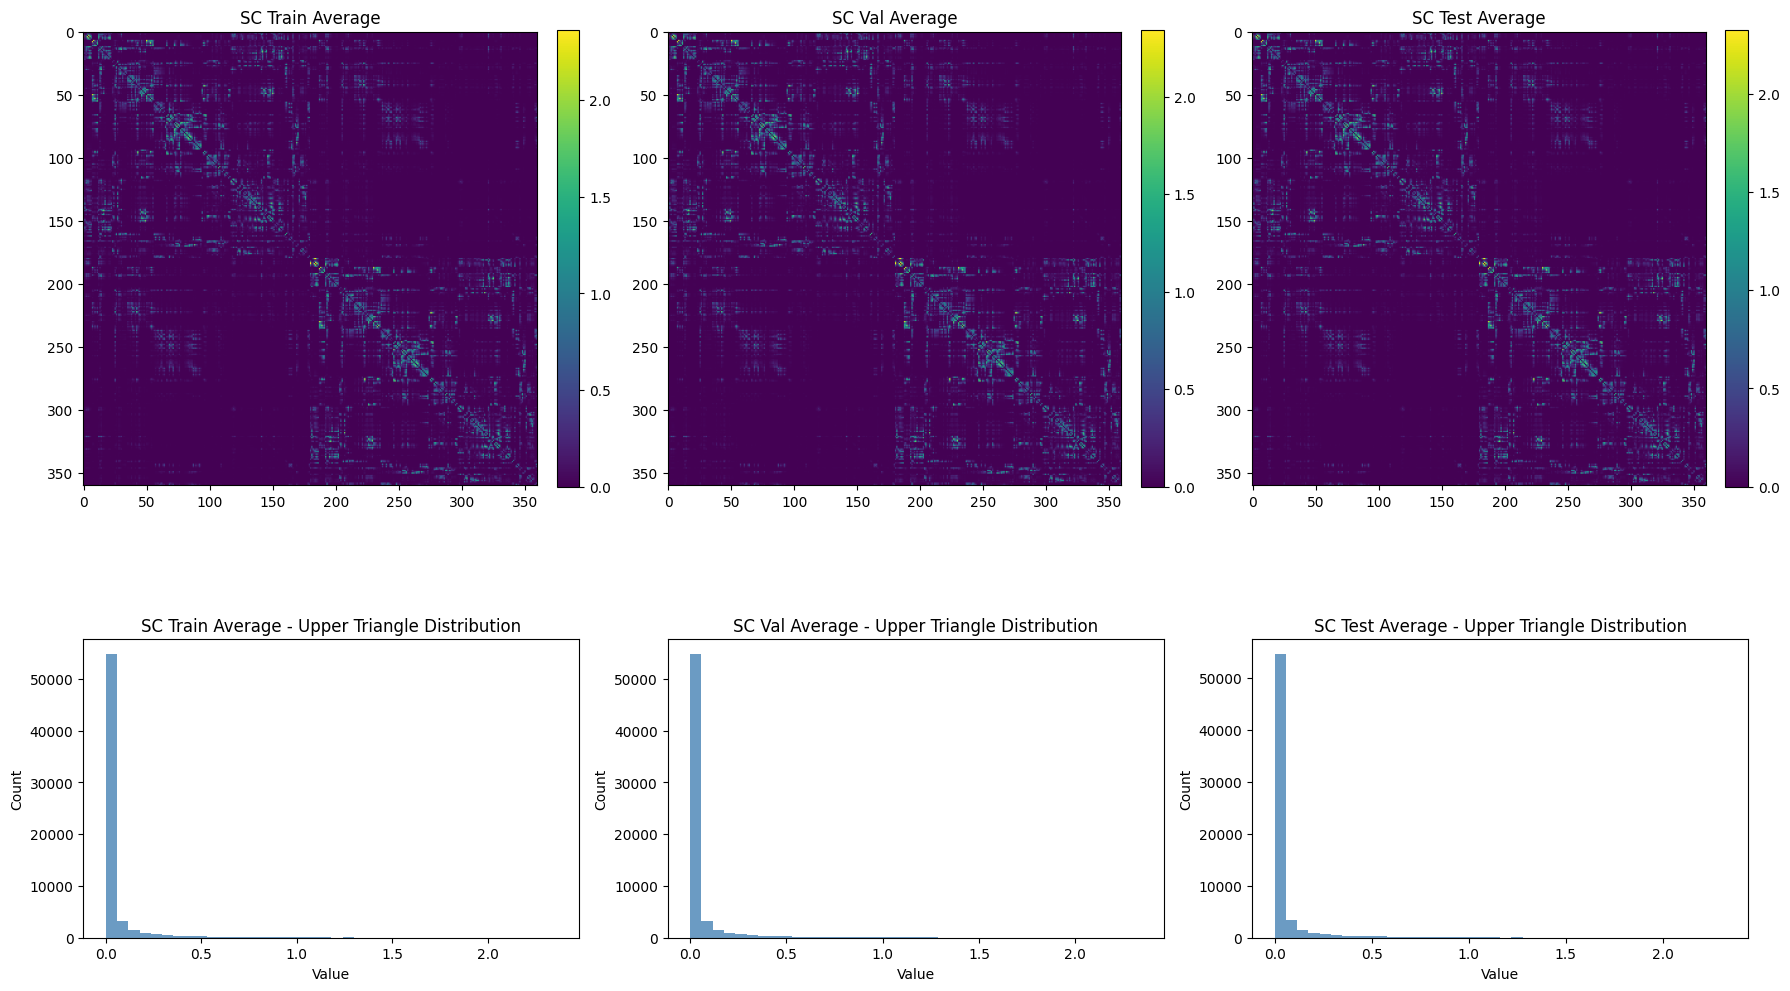

FC Train vs Val Pearson r: 0.9963651
FC Train vs Test Pearson r: 0.99826103
FC Val vs Test Pearson r: 0.9963004


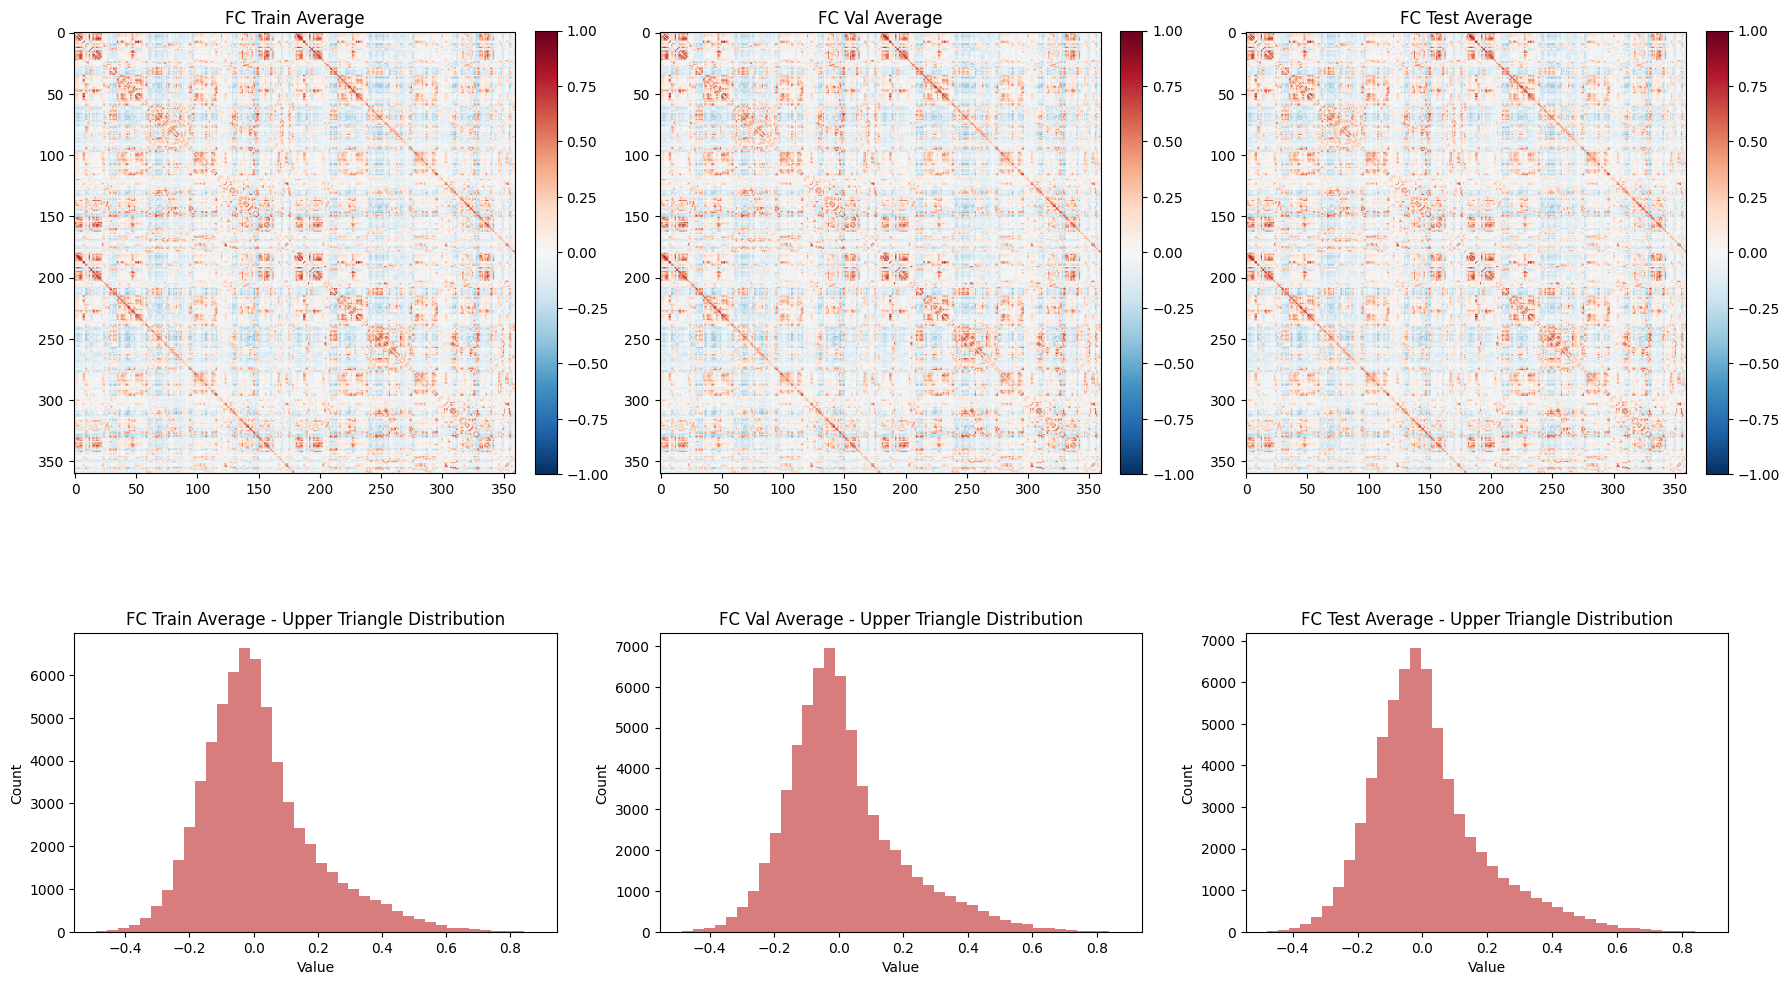

In [58]:
# Plot average SC matrices for train, val, test splits using tri2square
sc_tri_indices = np.triu_indices(sc_matrices.shape[1], k=1)
sc_train_avg_mat = tri2square(HCP_Dataset.SC_train_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)
sc_val_avg_mat = tri2square(HCP_Dataset.SC_val_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)
sc_test_avg_mat = tri2square(HCP_Dataset.SC_test_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average SCs
from scipy.stats import pearsonr

def tri_corr(mat1, mat2):
    # extract upper triangle without diagonal, flatten
    iu = np.triu_indices_from(mat1, k=1)
    return pearsonr(mat1[iu], mat2[iu])[0]

print("SC Train vs Val Pearson r:", tri_corr(sc_train_avg_mat, sc_val_avg_mat))
print("SC Train vs Test Pearson r:", tri_corr(sc_train_avg_mat, sc_test_avg_mat))
print("SC Val vs Test Pearson r:", tri_corr(sc_val_avg_mat, sc_test_avg_mat))

# PLOT: imshow and histogram for each SC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
sc_avg_mats = [sc_train_avg_mat, sc_val_avg_mat, sc_test_avg_mat]
sc_titles = ["SC Train Average", "SC Val Average", "SC Test Average"]

for i, (mat, title) in enumerate(zip(sc_avg_mats, sc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='viridis')
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='steelblue', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()

# Plot average FC matrices for train, val, test splits using tri2square
fc_tri_indices = np.triu_indices(fc_matrices.shape[1], k=1)
fc_train_avg_mat = tri2square(HCP_Dataset.FC_train_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)
fc_val_avg_mat = tri2square(HCP_Dataset.FC_val_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)
fc_test_avg_mat = tri2square(HCP_Dataset.FC_test_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average FCs
print("FC Train vs Val Pearson r:", tri_corr(fc_train_avg_mat, fc_val_avg_mat))
print("FC Train vs Test Pearson r:", tri_corr(fc_train_avg_mat, fc_test_avg_mat))
print("FC Val vs Test Pearson r:", tri_corr(fc_val_avg_mat, fc_test_avg_mat))

# PLOT: imshow and histogram for each FC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
fc_avg_mats = [fc_train_avg_mat, fc_val_avg_mat, fc_test_avg_mat]
fc_titles = ["FC Train Average", "FC Val Average", "FC Test Average"]

for i, (mat, title) in enumerate(zip(fc_avg_mats, fc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='indianred', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()


### PCA info loss eval

Loadings shape (n_components, n_features): (683, 64620)
Train scores shape (n_train_samples, n_components): (683, 683)


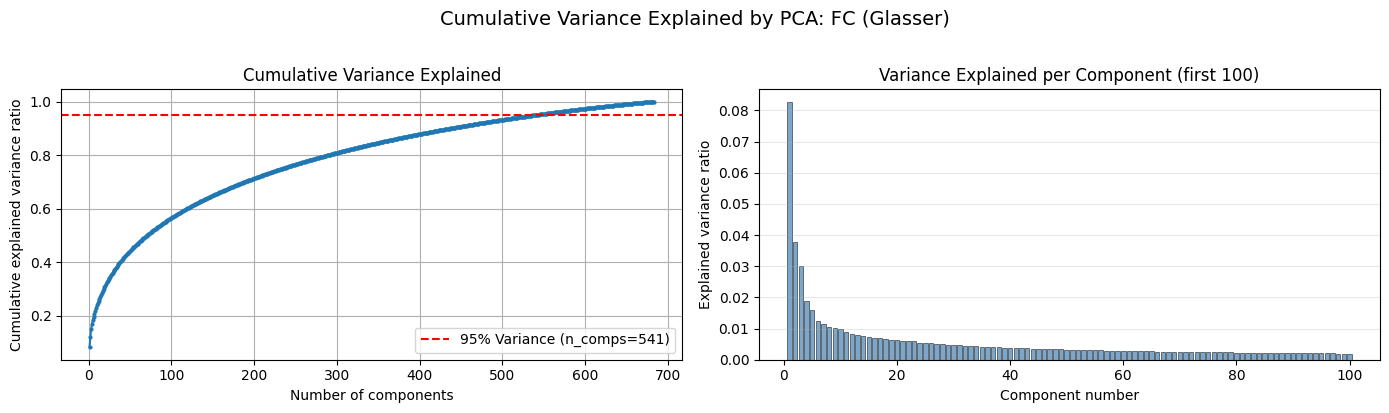

128 components: Train R^2: 0.58524  Val R^2: 0.35478  Test R^2: 0.37567
256 components: Train R^2: 0.74561  Val R^2: 0.40393  Test R^2: 0.42183
512 components: Train R^2: 0.92866  Val R^2: 0.45083  Test R^2: 0.46657


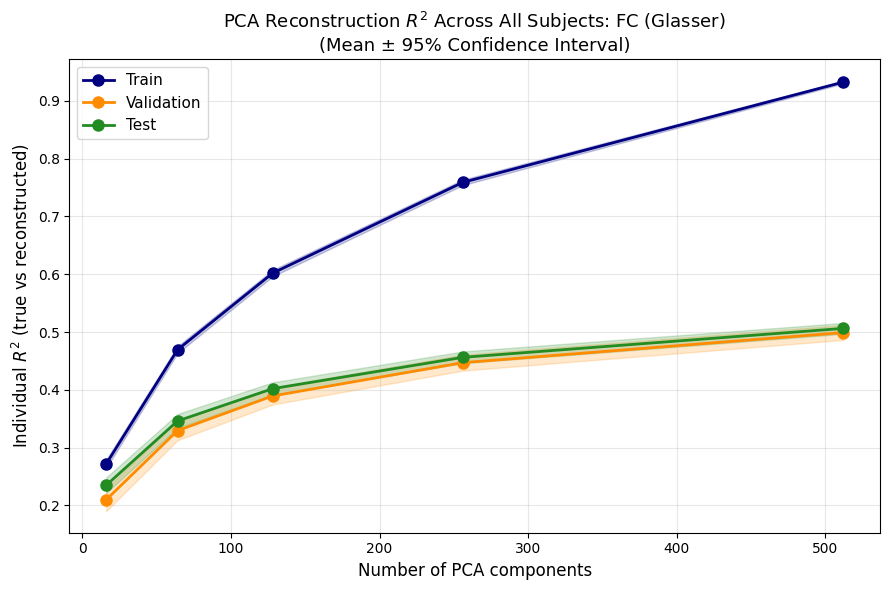

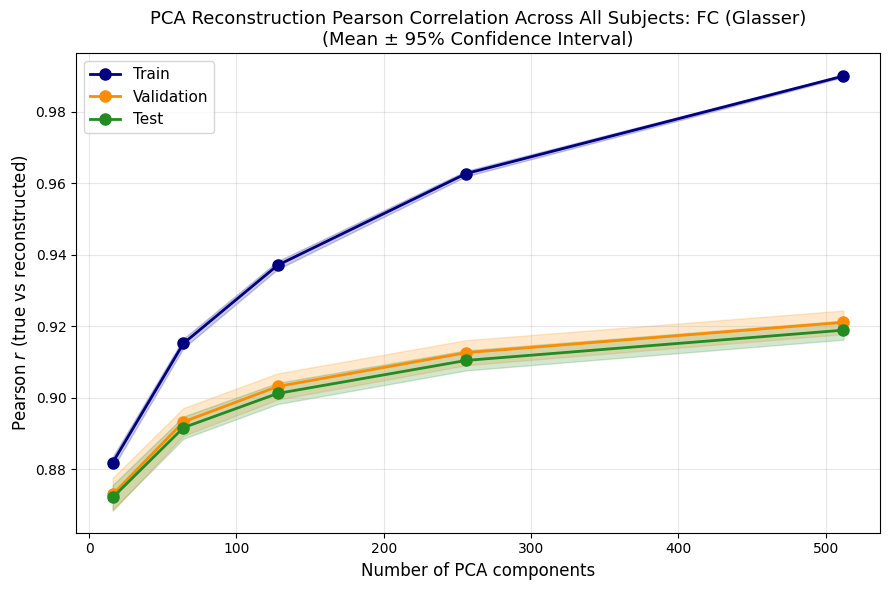

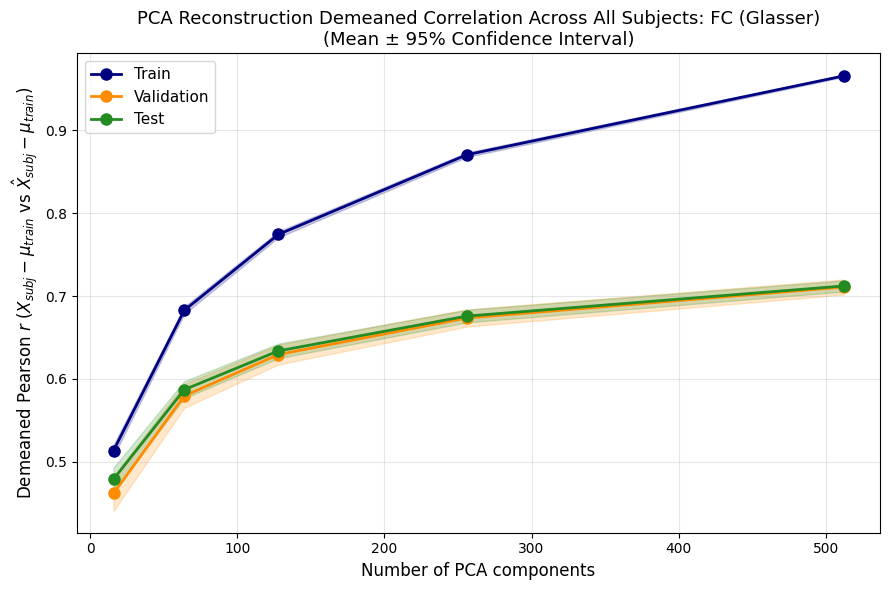

In [59]:
# how much info loss is attributable to PCA?

import models
import importlib
importlib.reload(models)
from models import *

# Example usage:
FC_train_np = HCP_Dataset.FC_train.detach().cpu().numpy()
FC_val_np = HCP_Dataset.FC_val.detach().cpu().numpy()
FC_test_np = HCP_Dataset.FC_test.detach().cpu().numpy()

pca, scores_dict, loadings = run_pca_and_plot(
    FC_train_np, FC_val_np, FC_test_np, 
    train_ids=HCP_Dataset.train_subject_ids, 
    val_ids=HCP_Dataset.val_subject_ids, 
    test_ids=HCP_Dataset.test_subject_ids,
    modality="FC", parcellation="Glasser")



Loadings shape (n_components, n_features): (683, 64620)
Train scores shape (n_train_samples, n_components): (683, 683)


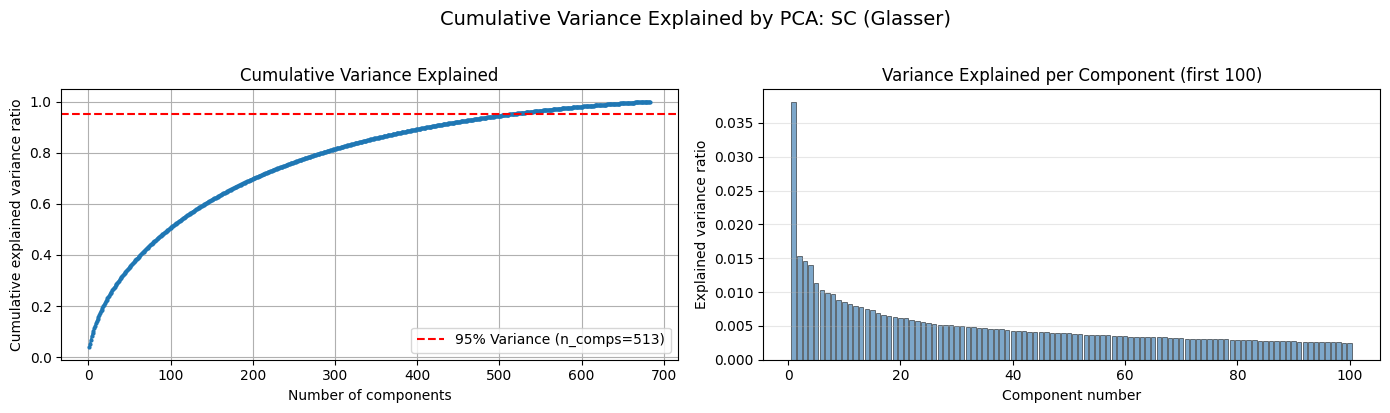

128 components: Train R^2: 0.40487  Val R^2: 0.10091  Test R^2: 0.11184
256 components: Train R^2: 0.59228  Val R^2: 0.07313  Test R^2: 0.09387
512 components: Train R^2: 0.86372  Val R^2: -0.03034  Test R^2: 0.01363


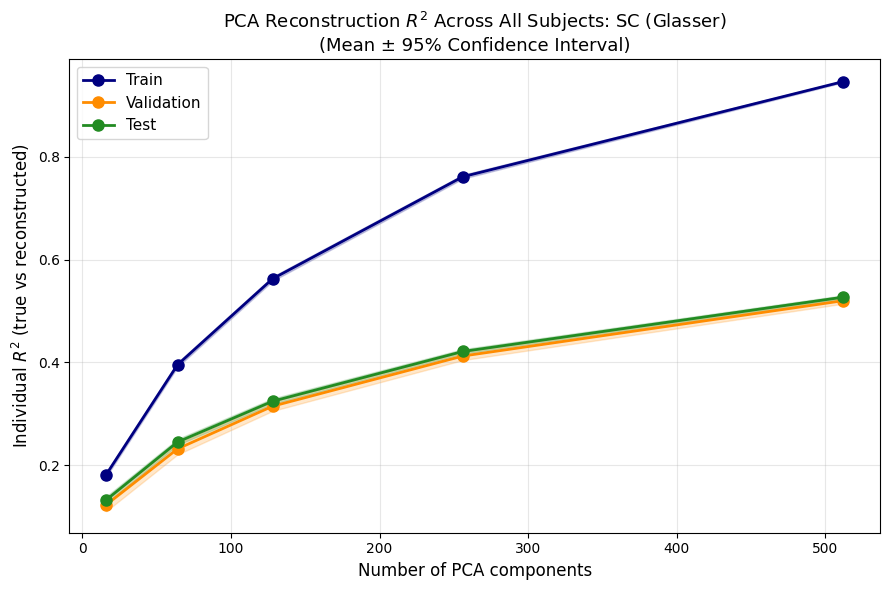

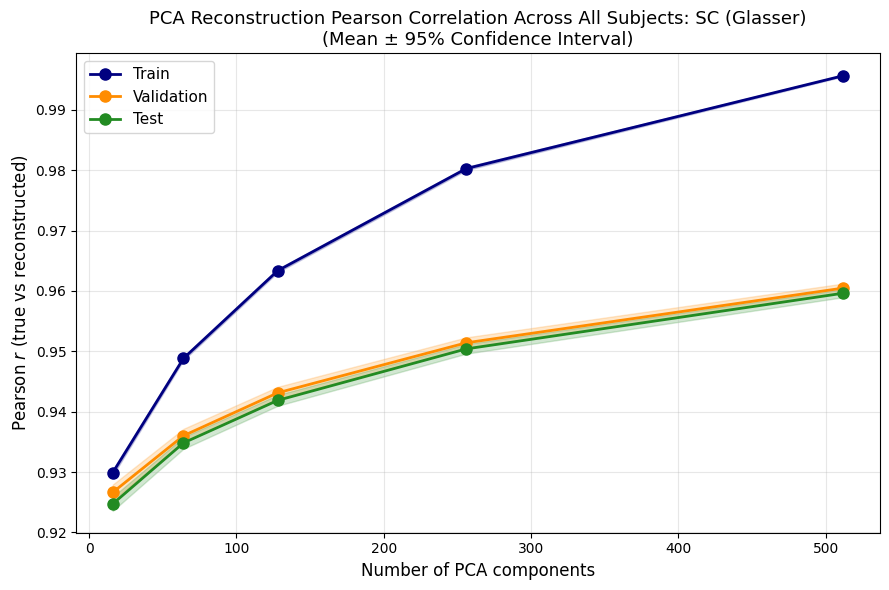

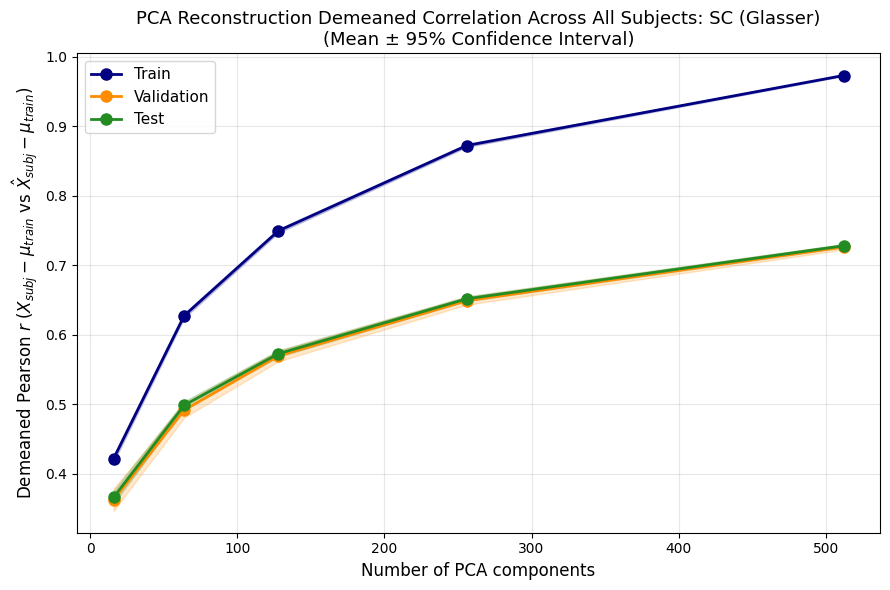

In [60]:
# how much info loss is attributable to PCA? (for SC)

import models
import importlib
importlib.reload(models)
from models import *

# Example usage for SC:
SC_train_np = HCP_Dataset.SC_train.detach().cpu().numpy()
SC_val_np = HCP_Dataset.SC_val.detach().cpu().numpy()
SC_test_np = HCP_Dataset.SC_test.detach().cpu().numpy()

pca, scores_dict, loadings = run_pca_and_plot(
    SC_train_np, SC_val_np, SC_test_np, 
    train_ids=HCP_Dataset.train_subject_ids, 
    val_ids=HCP_Dataset.val_subject_ids, 
    test_ids=HCP_Dataset.test_subject_ids,
    modality="SC", parcellation="Glasser")

